In [1]:
import logging
import sys
import datetime
import pickle
from icecream import ic
from tqdm import tqdm

In [2]:

def time_now():
  
    return f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} |"

ic.configureOutput(prefix=time_now)

ic.configureOutput(includeContext=True) 

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt;
np.random.seed(42);

In [4]:
from sklearn.metrics import roc_auc_score;
from sklearn.metrics import classification_report;

In [14]:
import torch_geometric as pyg
from torch_geometric.nn import GCNConv 
from torch_geometric.nn import SAGEConv, to_hetero ,LSTMAggregation
import  torch.nn as nn
import torch.nn.functional as F
import torch 
from torch_geometric.loader import DataLoader

In [356]:
file_name = "data_list.pkl"
open_file = open(file_name, "rb")
data_list = pickle.load(open_file)
open_file.close()


In [357]:
NUM_GRAPHS_PER_BATCH=10

In [358]:
target_class_1=[]
target_class_0=[]
for num, data in enumerate(data_list):
    target_class=data['target'].y.item()
    if target_class ==0:
        target_class_0.append(data)
    else:
        target_class_1.append(data)
        
if len(target_class_1)>len(target_class_0):
        target_class_0_balanced=[]
        index_list=np.arange(len(target_class_0))
        index_balanced=list(np.random.choice(index_list,len(target_class_1),replace=True))
        for i in index_balanced:
            target_class_0_balanced.append(target_class_0[i])
target_class_1.extend(target_class_0_balanced)

In [359]:
taget_balanced=target_class_1.copy()

In [125]:
loader_classes=[]
for num, data in enumerate(data_list):
    loader_classes.append(data['target'].y.view(1,-1)[0].numpy())
loader_classes_np=np.concatenate(loader_classes)
np.mean(loader_classes_np)

0.5616666666666666

In [126]:
loader_classes=[]
for num, data in enumerate(taget_balanced):
    loader_classes.append(data['target'].y.view(1,-1)[0].numpy())
loader_classes_np=np.concatenate(loader_classes)
np.mean(loader_classes_np)

0.5

## Best
batch size 25

In [364]:
NUM_GRAPHS_PER_BATCH=25
data_size=int(len(taget_balanced)*.80)
loader = DataLoader(taget_balanced[:data_size], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(taget_balanced[data_size:], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_data_list=data_list[data_size:]

In [360]:
balanced_data_size=int(len(taget_balanced)*.80)

In [330]:
data_list[0]

HeteroData(
  atom={ x=[2, 2] },
  lo={ x=[31, 1] },
  target={
    x=[1, 1],
    y=[1, 1]
  },
  lm={ x=[2, 1] },
  (lo, lo_atom, atom)={ edge_index=[2, 2] },
  (lo, lo_lo, lo)={ edge_index=[2, 41] },
  (lo, lo_target, target)={ edge_index=[2, 1] },
  (atom, atom_atom, atom)={ edge_index=[2, 1] },
  (atom, atom_target, target)={ edge_index=[2, 0] },
  (lo, lo_lm, lm)={ edge_index=[2, 2] }
)

In [331]:
batch=list(loader)[0]

## Best 
hidden_channels=100
out_channels=100

In [332]:
hidden_channels=75
out_channels=50
class GNN_Embeddings(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=False)
        self.actfn1=nn.ReLU()
        
        #self.conv2 = SAGEConv((-1, -1), hidden_channels,requires_grad=False)
        #self.actfn2=nn.ReLU()
        
        self.out=nn.Linear(hidden_channels,out_channels)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x, edge_index):
        
        # First Message Passing layer
        x = self.actfn1(self.conv1(x, edge_index))
        x= F.dropout(x,p=.8,training=self.training)
        
        #x = self.actfn2(self.conv2(x, edge_index))
        #x= F.dropout(x,p=.8,training=self.training)
        
        out=self.out(x)
        
        return out

In [333]:
import torch
from torch import nn

input_dim=out_channels
hidden_dim=10
output_dim=2

 
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid= nn.Sigmoid()
        
    def forward(self, x):
        x, hidden_state = self.lstm(x)
        x = self.linear(x)
        x= self.sigmoid(x)
        
        return x 


In [334]:
class GNNRNN(nn.Module):
    def __init__(self):
        super(GNNRNN, self).__init__()
        
        
        self.model_embedding=GNN_Embeddings()
        self.model_embedding = to_hetero(self.model_embedding, batch.metadata())
        self.lstm = LSTM_Model()

    def forward(self, x,edges):
        node_embeddings = self.model_embedding(x,edges)

        # Select the node embeddings for the user node type
        user_embeddings = node_embeddings["target"]

        # Pass the user embeddings through the RNN
        rnn_outputs = self.lstm(user_embeddings)
      
        return rnn_outputs

In [335]:
accuracy

0.0

In [365]:
hidden_state=None
new_model=GNNRNN()
new_model.train()

new_model(batch.x_dict, batch.edge_index_dict)
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(new_model.parameters(),lr=0.001,weight_decay=5e-12)
#,weight_decay=5e-12
loss_list=[]
accuracy_list=[]

for epoch in range(100):
    epoch_accuracy=[]
    epoch_loss=[]
    hidden_state=None
    for batch_num, batch in enumerate(loader):
        new_model.train()
        
        optimizer.zero_grad()   
        out=new_model(batch.x_dict, batch.edge_index_dict) 

        loss=criterion(out, batch['target'].y.view(1,-1)[0])
        loss.backward()
        optimizer.step()
        train_correct=out.argmax(dim=1)==batch['target'].y.view(1,-1)[0]
        train_acc=train_correct*1
        accuracy=(sum(train_correct*1)/train_correct.shape[0]).item()
        
        epoch_accuracy.append(accuracy)
        if batch_num%5==0:
            model_performace='epoch : {} | batch : {} | loss : {:.5f} | accuracy : {:.3f}'.format(epoch+1,batch_num,loss.item(),accuracy)
            ic(model_performace)
        loss_list.append(loss.item())
        accuracy_list.append(accuracy)
        epoch_loss.append(loss.item())
    epoch_performance=f'accuracy : {np.mean(epoch_accuracy)} | loss : {np.mean(epoch_loss)}'
    ic(epoch,epoch_performance)


2023-10-19 10:03:56 |1879062120.py:32 in <module>
                     model_performace: 'epoch : 1 | batch : 0 | loss : 0.69946 | accuracy : 0.440'
2023-10-19 10:03:57 |1879062120.py:32 in <module>
                     model_performace: 'epoch : 1 | batch : 5 | loss : 0.70457 | accuracy : 0.400'
2023-10-19 10:03:58 |1879062120.py:32 in <module>
                     model_performace: 'epoch : 1 | batch : 10 | loss : 0.68438 | accuracy : 0.600'
2023-10-19 10:03:59 |1879062120.py:32 in <module>
                     model_performace: 'epoch : 1 | batch : 15 | loss : 0.67508 | accuracy : 0.680'
2023-10-19 10:04:00 |1879062120.py:32 in <module>
                     model_performace: 'epoch : 1 | batch : 20 | loss : 0.66785 | accuracy : 0.720'
2023-10-19 10:04:02 |1879062120.py:32 in <module>
                     model_performace: 'epoch : 1 | batch : 25 | loss : 0.67189 | accuracy : 0.560'
2023-10-19 10:04:03 |1879062120.py:32 in <module>
                     model_performace: 'epoch : 1 | 

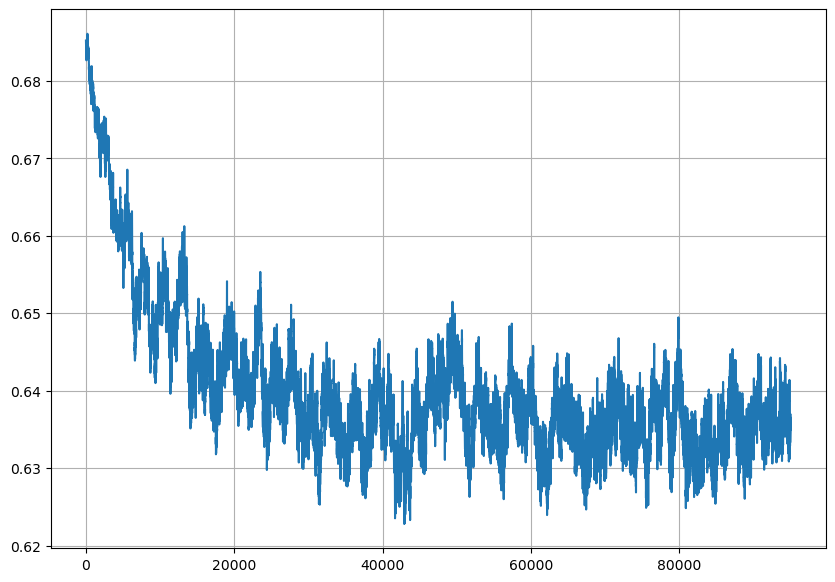

In [349]:
plt.figure(figsize=(10,7))
mvg_steps=1000
loss_moving_avg=[]
for i in range(len(loss_list)-mvg_steps):
    loss_moving_avg.append(np.mean(loss_list[i:i+mvg_steps]))
plt.grid()
#plt.plot(loss_list)
plt.plot(loss_moving_avg)


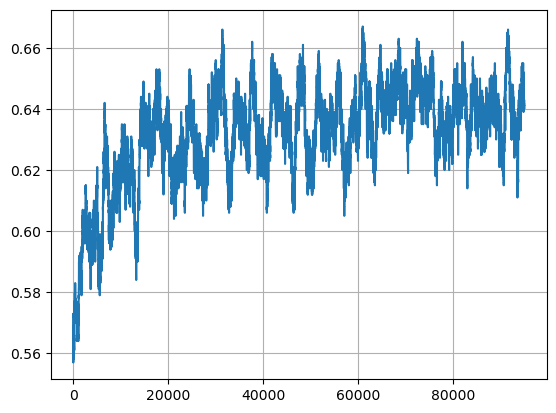

In [350]:
acc_moving_avg=[]

for i in range(len(accuracy_list)-mvg_steps):
    acc_moving_avg.append(np.mean(accuracy_list[i:i+mvg_steps]))
#plt.plot(accuracy_list)
plt.plot(acc_moving_avg)
plt.grid()

In [340]:
model_name='model_'+f"{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

In [341]:
#torch.save(new_model.state_dict(), model_name)


In [355]:
test_accuracy=[]
new_model.eval()
test_target_list=[]
test_out_list=[]
for test_data in tqdm(test_data_list):
    out=new_model(test_data.x_dict, test_data.edge_index_dict) 
    test_correct=out.argmax(dim=1)==test_data['target'].y.view(1,-1)[0]
    test_acc=test_correct*1
    accuracy=(sum(test_acc*1)/test_acc.shape[0]).item()
    test_accuracy.append(accuracy)
    test_target_list.append(test_data['target'].y.view(1,-1)[0].item())
    test_out_list.append(out.argmax(dim=1).item())
print(np.mean(test_accuracy))
print(roc_auc_score(test_target_list,test_out_list))

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:07<00:00, 31.78it/s]


0.6916666666666667
0.6941798941798942


In [ ]:
class GNNRNN_2(nn.Module):
    def __init__(self):
        super(GNNRNN, self).__init__()
        
        
        self.model_embedding=GNN_Embeddings()
        self.model_embedding = to_hetero(self.model_embedding, batch.metadata())
        self.lstm = LSTM_Model()

    def forward(self, data):
        target_embeddings_list=[]
        ic(user_embeddings_list)
        for i in data:
            node_embeddings = self.model_embedding(data.x_dict, data.edge_index_dict)
            target_embeddings = node_embeddings["target"]
            target_embeddings_list.append(target_embeddings)
        # Select the node embeddings for the user node type        
        stacked_tensor=torch.stack(target_embeddings_list,dim=0)
        reshaped=stacked_tensor.permute(1,0,2).float()
        # Pass the user embeddings through the RNN
        rnn_outputs = self.lstm(user_embeddings)
      
        return rnn_outputs

In [ ]:
train_data=data_list[int(len(data_list)*.8):]
train_list=[]

sequnce_length=10
for i in range(len(train_data)-sequnce_length):
    X_train_list.append(train_data[i:i+sequnce_length])
    